## XGBoost Regressor

The goal of this notebook is to train, tune, and evaluate the XGBoostRegressor, RF Regressor, and Baseline model.

In [1]:
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, accuracy_score
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("/content/final_modeling_dataset_new.csv")

In [3]:
df.head()

,Date,Close_SPY,High_SPY,Low_SPY,Open_SPY,Volume_SPY,Return,High_Low_Spread,Close_Open_Change,Close_to_High,...,is_quarter_end,Next_Open_SPY,vader_neg,vader_neu,vader_pos,vader_compound,finbert_positive,finbert_negative,finbert_neutral,Next_Open_Return
0,2018-01-31,249.531631,250.770875,248.451713,250.266344,108364800,0.000497,2.319162,-0.734713,1.239244,...,0,248.796838,0.088,0.826,0.086,0.3291,0.126446,0.026526,0.847028,-0.005872
1,2018-02-01,249.248260,250.558333,248.451606,248.796838,90102500,-0.001136,2.106727,0.451422,1.310072,...,0,247.920446,0.157,0.731,0.112,-0.9726,0.155686,0.243639,0.600675,-0.003523
2,2018-02-02,243.822098,248.053244,243.786683,247.920446,173174800,-0.021770,4.266561,-4.098348,4.231146,...,0,242.051753,0.051,0.860,0.089,0.2617,0.058793,0.085663,0.855543,-0.023672
3,2018-02-05,233.624847,244.176173,233.076042,242.051753,294681800,-0.041823,11.100131,-8.426906,10.551326,...,0,230.093090,0.131,0.791,0.077,-0.9922,0.033054,0.902048,0.064897,-0.049405
4,2018-02-06,238.227875,238.732433,228.995478,230.093090,355026800,0.019703,9.736955,8.134785,0.504558,...,0,237.670141,0.125,0.798,0.077,-0.9812,0.011398,0.960801,0.027800,0.032930


creating a holdout set/model training set:
- time-based split so no leakage

In [4]:
model_df = df.copy()
model_df = model_df.sort_index()
n = len(model_df)
holdout_size = int(n * 0.20)

model_df['split'] = 'train_val'
model_df.iloc[-holdout_size:, model_df.columns.get_loc('split')] = 'holdout'
model_df = model_df.drop(columns=["Date"], errors="ignore")

In [5]:
train_val = model_df[model_df['split'] == 'train_val']
holdout   = model_df[model_df['split'] == 'holdout']

In [6]:
target_col = "Next_Open_SPY"

cols_to_drop_from_X = [
    "split",
    target_col,
    "Next_Open_Return",
]
feature_cols = [c for c in model_df.columns if c not in cols_to_drop_from_X]

# Build X and y for train/holdout
X_train_val = train_val[feature_cols]
y_train_val = train_val[target_col]

X_holdout = holdout[feature_cols]
y_holdout = holdout[target_col]

print("Train/Val shape:", X_train_val.shape, y_train_val.shape)
print("Holdout shape:",   X_holdout.shape,   y_holdout.shape)

Train/Val shape: (496, 43) (496,)
Holdout shape: (123, 43) (123,)


## Baseline model performance

In [7]:
baseline_pred = X_holdout["Open_SPY"].values
baseline_mae = mean_absolute_error(y_holdout, baseline_pred)
baseline_rmse = np.sqrt(mean_squared_error(y_holdout, baseline_pred))
baseline_mape = np.mean(np.abs((y_holdout - baseline_pred) / y_holdout)) * 100

print("Baseline MAE :", baseline_mae)
print("Baseline RMSE:", baseline_rmse)
print("Baseline MAPE:", baseline_mape)

Baseline MAE : 4.5957256764376835
Baseline RMSE: 6.2233050709553455
Baseline MAPE: 1.7454003634568023


In [ ]:
X_train_val.columns

Index(['Close_SPY', 'High_SPY', 'Low_SPY', 'Open_SPY', 'Volume_SPY', 'Return',
       'High_Low_Spread', 'Close_Open_Change', 'Close_to_High', 'Close_to_Low',
       'Return_1', 'Return_2', 'Return_3', 'Return_5', 'Return_10',
       'Momentum_3', 'Momentum_7', 'Close_lag1', 'Close_lag2', 'Close_lag3',
       'MA_5', 'MA_20', 'Close_minus_MA_5', 'Close_minus_MA_20',
       'Volatility_5', 'Volatility_10', 'Volatility_20', 'TR', 'ATR_14',
       'Prev_Day_Overnight_Return', 'day_of_week', 'month', 'day_of_month',
       'week_of_month', 'is_month_end', 'is_quarter_end', 'vader_neg',
       'vader_neu', 'vader_pos', 'vader_compound', 'finbert_positive',
       'finbert_negative', 'finbert_neutral'],
      dtype='object')

## XGBRegressor baseline performance

In [ ]:
from xgboost import XGBRegressor

model = XGBRegressor(
    n_estimators=300,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
)

model.fit(X_train_val, y_train_val)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=300,
             n_jobs=None, num_parallel_tree=None, ...)

In [ ]:
y_pred = model.predict(X_holdout)

# eval
mae = mean_absolute_error(y_holdout, y_pred)
rmse = np.sqrt(mean_squared_error(y_holdout, y_pred))
mape = np.mean(np.abs((y_holdout - y_pred) / y_holdout)) * 100
r2 = r2_score(y_holdout, y_pred)

print(f"MAE  : {mae:.4f}")
print(f"RMSE : {rmse:.4f}")
print(f"MAPE : {mape:.2f}%")
print(f"R^2  : {r2:.4f}")

MAE  : 3.7533
RMSE : 5.2490
MAPE : 1.42%
R^2  : 0.9559


The model achieved strong forecasting performance on the holdout period, with MAE = 3.75, RMSE = 5.2490, MAPE = 1.42%, and R² = 0.956. This indicates that the model explains ~96% of the variance in next-day opening prices and predicts the SPY's next open within ~1.4% relative error on average.

In [ ]:
#TODO: gridsearch

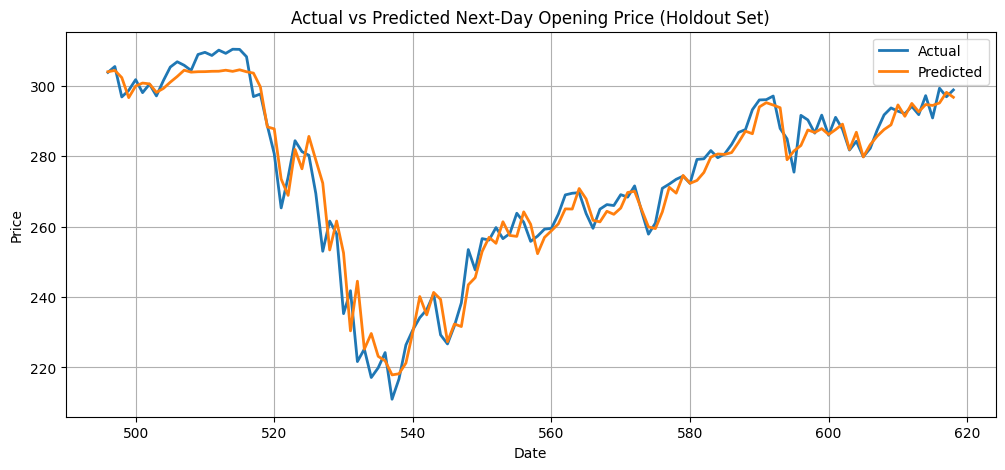

In [ ]:
plt.figure(figsize=(12, 5))
plt.plot(y_holdout.index, y_holdout, label="Actual", linewidth=2)
plt.plot(y_holdout.index, y_pred, label="Predicted", linewidth=2)
plt.title("Actual vs Predicted Next-Day Opening Price (Holdout Set)")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.show()



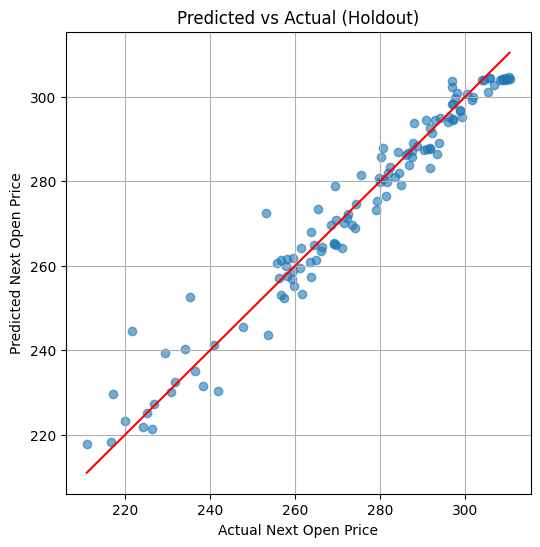

In [ ]:
plt.figure(figsize=(6,6))
plt.scatter(y_holdout, y_pred, alpha=0.6)
plt.xlabel("Actual Next Open Price")
plt.ylabel("Predicted Next Open Price")
plt.title("Predicted vs Actual (Holdout)")
plt.grid(True)
plt.plot([y_holdout.min(), y_holdout.max()],
         [y_holdout.min(), y_holdout.max()],
         color='red')  # perfect prediction line
plt.show()

Shap values for XGB model

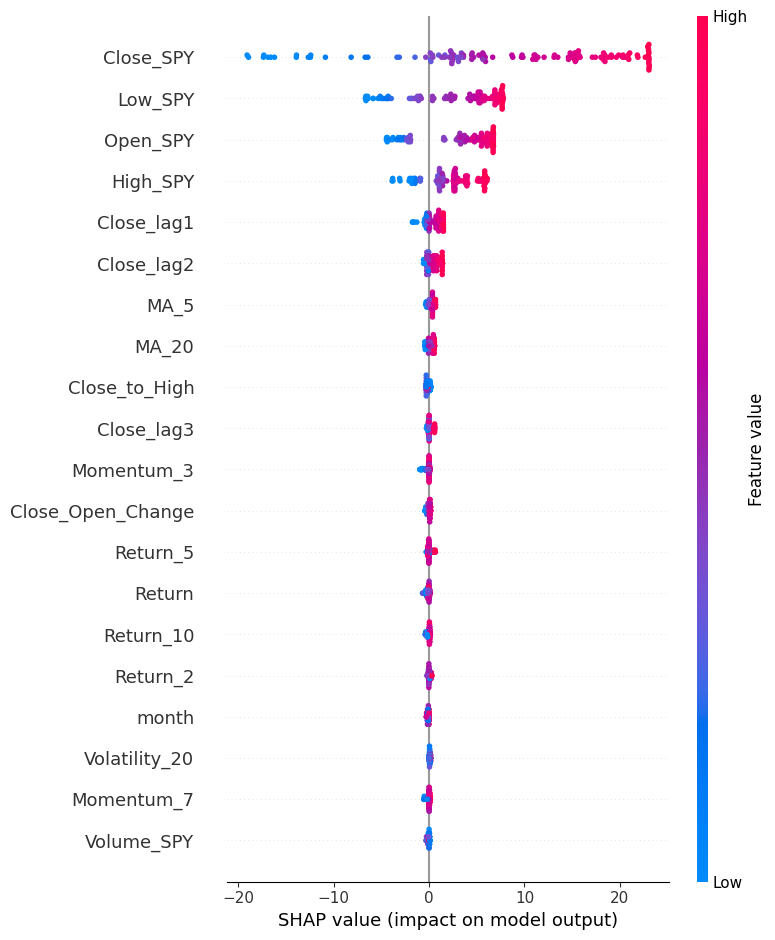

In [ ]:
import shap
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_holdout)
shap.summary_plot(shap_values, X_holdout, plot_type="dot")

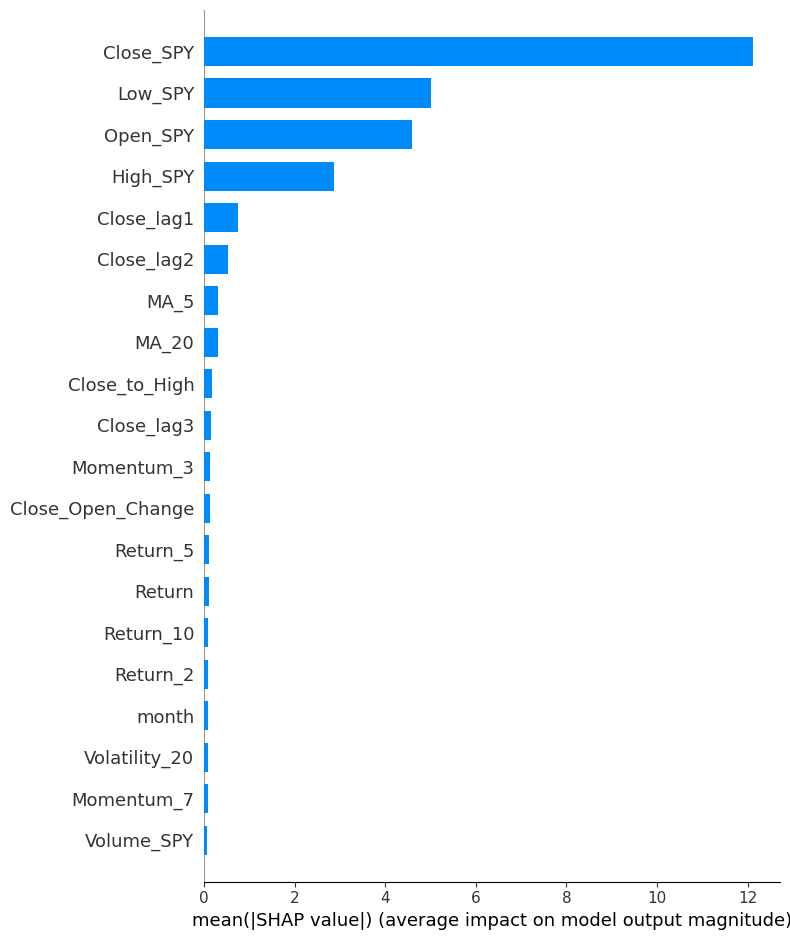

In [ ]:
shap.summary_plot(shap_values, X_holdout, plot_type="bar")

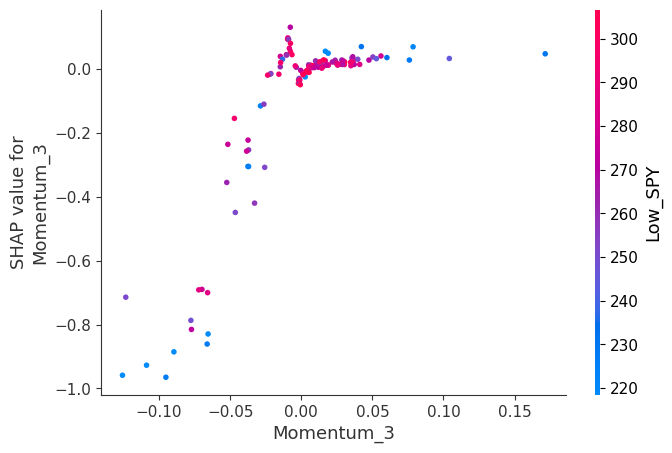

In [ ]:
shap.dependence_plot("Momentum_3", shap_values, X_holdout)

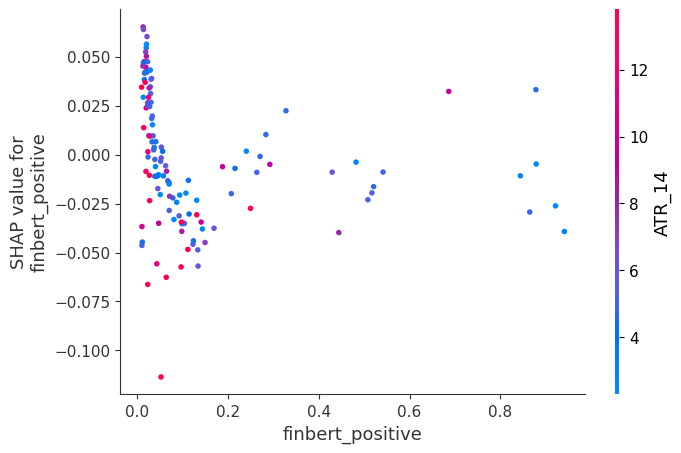

In [ ]:
shap.dependence_plot("finbert_positive", shap_values, X_holdout)

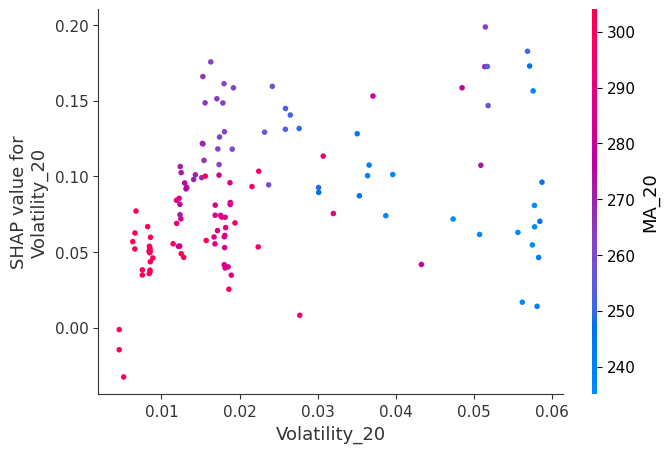

In [ ]:
shap.dependence_plot("Volatility_20", shap_values, X_holdout)

## Random Forest

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

baseline random forest model

In [ ]:
rf = RandomForestRegressor(
    n_estimators=300,
    max_depth=12,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train_val, y_train_val)

y_pred_rf = rf.predict(X_holdout)

print("RF MAE :", mean_absolute_error(y_holdout, y_pred_rf))
print("RF RMSE:", np.sqrt(mean_squared_error(y_holdout, y_pred_rf)))
print("RF MAPE:", np.mean(np.abs((y_holdout - y_pred_rf) / y_holdout))*100)
print("RF R2  :", r2_score(y_holdout, y_pred_rf))

RF MAE : 4.288265899023357
RF RMSE: 6.083335619584307
RF MAPE: 1.6146914362667384
RF R2  : 0.9407148067400499
